In [16]:
from get_bifurcations import get_bifurcations
from scipy.interpolate import UnivariateSpline,interp1d

from crnpy.parser import fromcrn
from crnpy.colors import cyan,yellow
from matplotlib.pyplot import *

from numpy import *
from scipy.interpolate import interp2d
from json import loads,dumps

from os import system
from os.path import isfile
from re import finditer,sub,search

from matplotlib.pyplot import *
from numpy import *
from scipy.interpolate import interp2d

from numpy.random import normal
from scipy.interpolate import UnivariateSpline

 [parser] ignoring directive simulator 
 [model]  setting spatial directive


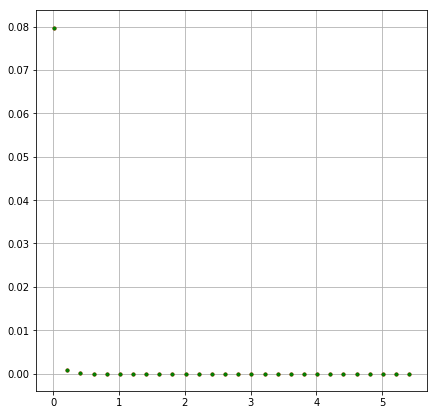

In [17]:

file_path = 'normal-form.crn'
self = fromcrn(file_path)
self.lacI[0] = 0.1
self.tetR[0] = 0.1

figure(figsize=(7,7))
for i in range(550) :
    self.time_step()

    if i % 20 == 0 :
        plot(self.time,self.lacI[0],'r.')
        plot(self.time,self.tetR[0],'g.')
    
grid(True)

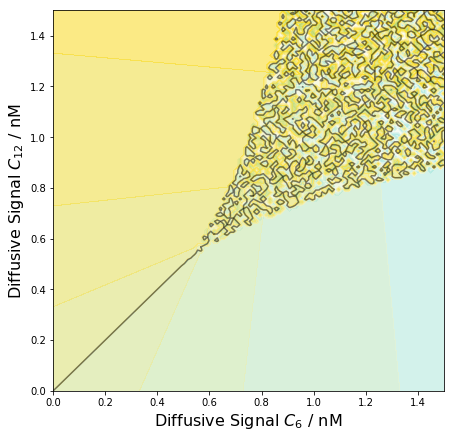

In [25]:
C6=0.6;C12=1.2
t_final = 1.0
width = 0.4

N = 120
c6_range = [0,self._xmax * C6 / width]
c12_range = [0,self._xmax * C6 / width]

c = linspace(*c6_range,num=N)
cdash = linspace(*c12_range,num=N)

c6,c12 = meshgrid(c,cdash,copy=False)
c_grid = dstack([c6,c12])

# calculation of steady states
steady_state = self.get_steady_state(c_grid,logspace=False)

T = steady_state[:,:,self.nontrivials.index('tetR')]
L = steady_state[:,:,self.nontrivials.index('lacI')]

figure(figsize=(7,7))

contourf(c6,c12,
         L,
         cmap='cyan',alpha=0.5)
contourf(c6,c12,
         T,
         cmap='yellow',alpha=0.5)
contour(c6,c12,
         T-L,levels=[0.0],
         colors=['k'],alpha=0.5)

xlabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)
ylabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16);

In [19]:
# def calculate(model,c6,c12,L,T):
    
#     Lattractor = array([
#         L[argmin(abs(c12[:,0]-c12x)),argmin(abs(c6[0]-c6x))]
#         for c6x,c12x in model.state['diffusables'] ]).reshape(-1)

#     Tattractor = array([
#         T[argmin(abs(c12[:,0]-c12x)),argmin(abs(c6[0]-c6x))]
#         for c6x,c12x in model.state['diffusables'] ]).reshape(-1)

#     space = linspace(0,model.xmax,len(Lattractor))
#     return space,Lattractor,Tattractor

def generate_frame(j,model):
    '''main program figure display'''

    fig = figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.plot(model.space,model.lacI,'-',color='darkcyan',linewidth=1,label='Gene Expression')
    ax1.plot(model.space,model.tetR,'-',color='gold',linewidth=1)

    for _ in range(20) :
        ss = model.get_steady_state(array([model.c6,model.c12]).T).T
        Lattractor = ss[model.nontrivials.index('lacI')]
        Tattractor = ss[model.nontrivials.index('tetR')]

        ax1.plot(model.space,Lattractor,'o',alpha=0.5,color='darkcyan')
        ax1.plot(model.space,Tattractor,'o',alpha=0.5,color='gold')

    ax1.plot(model.space,Lattractor,'o',alpha=0.5,color='darkcyan',label='Cell Equilibrium')
    ax1.legend()

    xticks(fontsize=16)
    yticks(fontsize=16)
    ax1.set_ylim(-2,2)

    ax1.set_xlabel(r'Space, $x$',fontsize=16)
    ax1.legend(fontsize=16,loc=1)

    mask = model.lacI > model.tetR

    ax2.contourf(c6,c12,
             L,
             cmap='cyan',alpha=0.5)
    ax2.contourf(c6,c12,
             T,
             cmap='yellow',alpha=0.5)
    ax2.contour(c6,c12,
             T-L,levels=[0.0],
             colors=['k'],alpha=0.5)

    ax2.plot(model.c6[mask],model.c12[mask],'.',color='darkcyan',ms=12)
    ax2.plot(model.c6[~mask],model.c12[~mask],'.',color='gold',ms=12)

    ax2.plot(C6,C12,'.',color='k',ms=20)
    ax2.text(C6,C12,'  steady state',fontsize=16)
    ax2.set_xlim(0, model._xmax * C6 / width)
    ax2.set_ylim(0, model._xmax * C6 / width)


    xticks(fontsize=16)
    yticks(fontsize=16)

    ax2.set_xlabel(r'Morphogen $A$ Concentration',fontsize=16)
    ax2.set_ylabel(r'Morphogen $B$ Concentration',fontsize=16)
    
    ax1.set_xticks([])
    ax2.set_xticks([])
    
    ax1.set_yticks([])
    ax2.set_yticks([])

    savefig(str(j).zfill(4)+'.png')
    close()

    return j+1
    
def create_animation(C6,C12):
    '''execute system commands to create animation from frames'''
    system('convert -delay 10 -loop 0 *.png c6-{}_c12-{}.gif'.format(C6,C12))
    system('rm *.png')

In [27]:
C6=0.6;C12=1.2
t_final = 0.6
width = 0.4

# import model from file
model = fromcrn(file_path)
model._dt = 1e-5
n_timepoints = 100

# initial condition
model.c6[model.space<width] = model._xmax * C6 / width
model.c12[model.space>(model._xmax-width)] = model._xmax * C12 / width

# create bifrucation figure
i,j = 0,0
while model.time < t_final :

    model.time_step()    
    if int(model.time/model._dt) % int(t_final/model._dt/n_timepoints) == 0 :
        j = generate_frame(j,model)
    i += 1

create_animation(C6,C12)

 [parser] ignoring directive simulator 
 [model]  setting spatial directive


In [9]:
for i in range(100) :model.time_step()

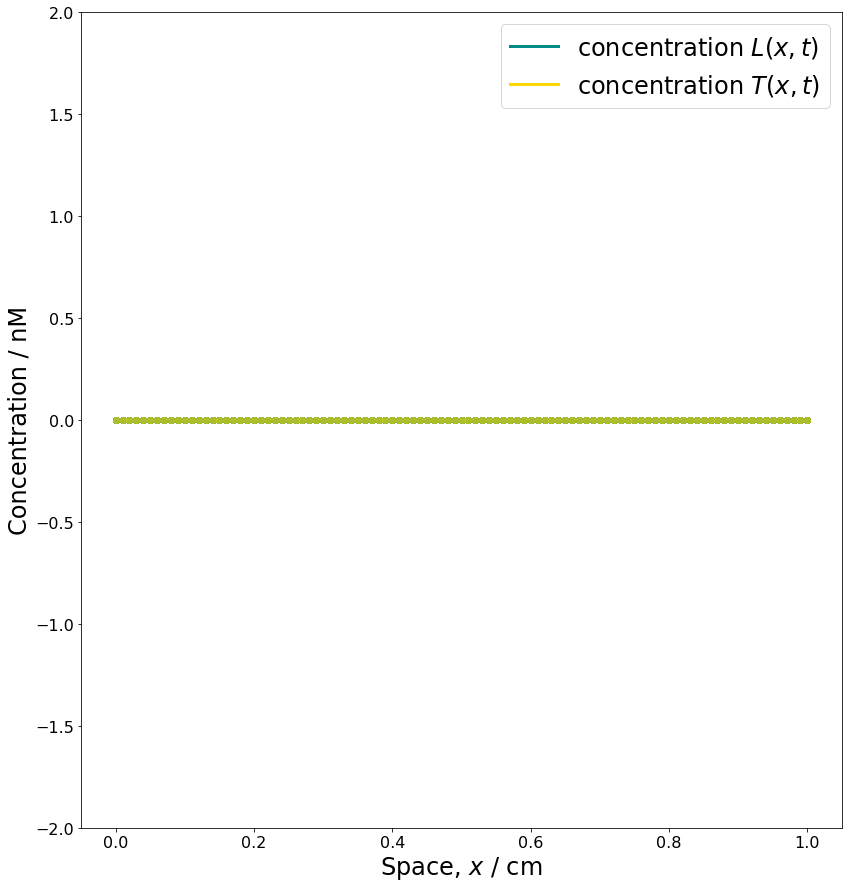

In [10]:
fig = figure(figsize=(30,15))
ax1 = fig.add_subplot(121)

ax1.plot(model.space,model.lacI,'-',color='darkcyan',
     label='concentration $L(x,t)$',linewidth=3)

ax1.plot(model.space,model.tetR,'-',color='gold',
     label='concentration $T(x,t)$',linewidth=3)

for _ in range(20) :
    ss = model.get_steady_state(array([model.c6,model.c12]).T).T
    Lattractor = ss[model.nontrivials.index('lacI')]
    Tattractor = ss[model.nontrivials.index('tetR')]

    ax1.plot(model.space,Lattractor,'o',alpha=0.5,color='darkcyan')
    ax1.plot(model.space,Tattractor,'o',alpha=0.5,color='gold')

ax1.legend()

xticks(fontsize=16)
yticks(fontsize=16)
ax1.set_ylim(-2,2)

ax1.set_xlabel(r'Space, $x$ / cm',fontsize=24)
ax1.set_ylabel(r'Concentration / nM',fontsize=24)
ax1.legend(fontsize=24)

No handles with labels found to put in legend.


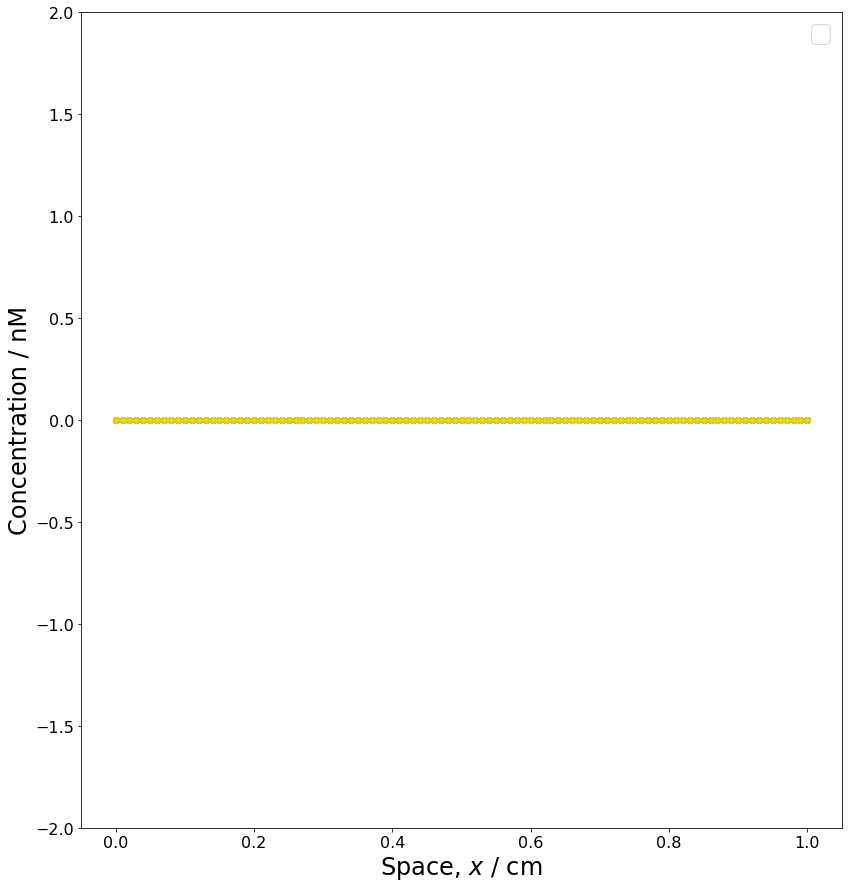

In [6]:
fig = figure(figsize=(30,15))
ax1 = fig.add_subplot(121)

Lattractor = array([
    L[argmin(abs(c12[:,0]-c12x)),argmin(abs(c6[0]-c6x))]
    for c6x,c12x in zip(model.c6,model.c12) ]).reshape(-1)

Tattractor = array([
    T[argmin(abs(c12[:,0]-c12x)),argmin(abs(c6[0]-c6x))]
    for c6x,c12x in zip(model.c6,model.c12) ]).reshape(-1)

space = linspace(0,self._xmax,len(Lattractor))
Tindex = argsort(Tattractor)
Lindex = argsort(Lattractor)

mask = model.lacI > model.tetR

ax1.plot(model.space,model.lacI,'.',color='darkcyan',ms=12)
ax1.plot(model.space,model.tetR,'.',color='gold',ms=12)

# ax1.plot(model.space[mask],model.lacI[mask],'.',color='darkcyan',ms=12,label=r'$L(x,t)$')
# ax1.plot(model.space[~mask],model.tetR[~mask],'.',color='gold',ms=12,label=r'$T(x,t)$')

ax1.plot(space[Lindex],Lattractor[Lindex],'o', mfc='none',
         color='darkcyan',linewidth=3)
ax1.plot(space[Tindex],Tattractor[Tindex],'o', mfc='none',
         color='gold',linewidth=3)  

xticks(fontsize=16)
yticks(fontsize=16)
ax1.set_ylim(-2,2)

ax1.set_xlabel(r'Space, $x$ / cm',fontsize=24)
ax1.set_ylabel(r'Concentration / nM',fontsize=24)
ax1.legend(fontsize=24)

In [28]:
for i,value in enumerate(linspace(0,5,100)):

    file_path = 'new.crn'
    self = fromcrn(file_path)

    self.growth = value

    N = 120

    c6_range = [-0.5,9]
    c12_range = [-0.5,7]

    c = logspace(*c6_range,num=N)
    cdash = logspace(*c12_range,num=N)

    # c6_range = [0,3]
    # c12_range = [0,3]

    # c = linspace(*c6_range,num=N)
    # cdash = linspace(*c12_range,num=N)

    c6,c12 = meshgrid(c,cdash,copy=False)
    c_grid = dstack([c6,c12])

    # calculation of steady states
    steady_state = self.get_steady_state(c_grid,logspace=True)

    T = steady_state[:,:,self.nontrivials.index('tetR')]
    L = steady_state[:,:,self.nontrivials.index('lacI')]

    figure(figsize=(7,7))
    title('growth = {0:.2f}, capacity = {1:.2f} '
          .format(self.growth,self.capacity),fontsize=16)


    contourf(c6,c12,
             L,
             cmap='cyan',alpha=0.5)
    contourf(c6,c12,
             T,
             cmap='yellow',alpha=0.5)
    contour(c6,c12,
             T-L,levels=[0.0],
             colors=['k'],alpha=0.5)
    xscale('log')
    yscale('log')

    xlabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)
    ylabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16);

    savefig(str(i).zfill(3)+'.png')
    close()

 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]  non-spatial directive
 [model]